# Preprocessing

### Loading Data

In [21]:
import pandas as pd

bank_df = pd.read_csv('bank.csv', delimiter=';')

file_path = 'adult.data'
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
    'hours-per-week', 'native-country', 'income'
]
adult_df = pd.read_csv(file_path, names=columns, na_values="?", skipinitialspace=True)



### Dropping Data

In [22]:
bank_df = bank_df.dropna()
adult_df = adult_df.dropna()

### Binning Columns

In [23]:
# Binary indicators for capital gains and losses
adult_df['positive_capital_gain'] = (adult_df['capital-gain'] > 0).astype(int)
adult_df['positive_capital_loss'] = (adult_df['capital-loss'] > 0).astype(int)

# Interaction feature between age and education-num
adult_df['age_education_interaction'] = adult_df['age'] * adult_df['education-num']

# Aggregating less common categories into 'Other'
top_occupations = adult_df['occupation'].value_counts().nlargest(5).index
adult_df['occupation_aggregated'] = adult_df['occupation'].apply(lambda x: x if x in top_occupations else 'Other')

top_countries = adult_df['native-country'].value_counts().nlargest(5).index
adult_df['native_country_aggregated'] = adult_df['native-country'].apply(lambda x: x if x in top_countries else 'Other')

# Binning age and hours-per-week
age_bins = [0, 25, 35, 45, 55, 65, 100]
age_labels = ['0-25', '26-35', '36-45', '46-55', '56-65', '66+']
adult_df['age_binned'] = pd.cut(adult_df['age'], bins=age_bins, labels=age_labels, right=False)

hours_bins = [0, 20, 30, 40, 50, 100]
hours_labels = ['0-20', '21-30', '31-40', '41-50', '51+']
adult_df['hours_per_week_binned'] = pd.cut(adult_df['hours-per-week'], bins=hours_bins, labels=hours_labels, right=False)


adult_df.columns


Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income', 'positive_capital_gain', 'positive_capital_loss',
       'age_education_interaction', 'occupation_aggregated',
       'native_country_aggregated', 'age_binned', 'hours_per_week_binned'],
      dtype='object')

In [24]:
adult_df = adult_df.drop(['age', 'hours-per-week', 'occupation', 'native-country'], axis=1)

In [25]:

# Aggregating less common categories into 'Other'
top_jobs = bank_df['job'].value_counts().nlargest(5).index
bank_df['job_aggregated'] = bank_df['job'].apply(lambda x: x if x in top_jobs else 'Other')

# Binning age and hours-per-week
age_bins = [0, 25, 35, 45, 55, 65, 75, 100]
age_labels = ['0-25', '26-35', '36-45', '46-55', '56-65', '66-75', '75+']
bank_df['age_binned'] = pd.cut(bank_df['age'], bins=age_bins, labels=age_labels, right=False)

bank_df = bank_df.drop(['age', 'job'], axis=1)

### Standardizing

In [26]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
num_cols = adult_df.select_dtypes(include=['int64', 'float64']).columns
# Fit the scaler to your data and then transform it
adult_df[num_cols] = scaler.fit_transform(adult_df[num_cols])



In [27]:
num_cols = bank_df.select_dtypes(include=['int64', 'float64']).columns

# Fit the scaler to your data and then transform it
bank_df[num_cols] = scaler.fit_transform(bank_df[num_cols])

### One Hot Encoding

In [28]:
bank_df = bank_df.drop('y', axis=1)
cat_cols = bank_df.select_dtypes(include=['object', 'category']).columns
bank_df_dbscan = pd.get_dummies(bank_df, columns=cat_cols)

In [29]:
cat_cols = adult_df.select_dtypes(include=['object', 'category']).columns
adult_df_dbscan = pd.get_dummies(adult_df, columns=cat_cols,  drop_first=True)

### Scripts

In [30]:
from sklearn.preprocessing import StandardScaler

### Only use after binning/aggregating and feature engineering
def preprocess(df):
    df = df.dropna()
    cat_cols = df.select_dtypes(include=['object']).columns
    df = pd.get_dummies(df, columns=cat_cols)

    scaler = StandardScaler()
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    df[num_cols] = scaler.fit_transform(df[num_cols])
    return df

# Convert to Transaction Format 

In [31]:
def dataframe_to_transactions(df):
    transactions = []
    for _, row in df.iterrows():
        transaction = []
        for col in df.columns:
            # Include categorical features directly, ensuring the column isn't the target 'y'
            if df[col].dtype == 'object':
                transaction.append(f"{col}={row[col]}")
            # Handle binned numerical features and other categorical types
            elif 'binned' in col or col == 'age_binned':
                transaction.append(f"{col}={str(row[col])}")
        transactions.append(transaction)
    return transactions

transactions_bank = dataframe_to_transactions(bank_df)
transactions_adult = dataframe_to_transactions(adult_df)



In [32]:
adult_df.columns

Index(['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
       'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'income',
       'positive_capital_gain', 'positive_capital_loss',
       'age_education_interaction', 'occupation_aggregated',
       'native_country_aggregated', 'age_binned', 'hours_per_week_binned'],
      dtype='object')

In [33]:
transactions_adult[0]

['workclass=State-gov',
 'education=Bachelors',
 'marital-status=Never-married',
 'relationship=Not-in-family',
 'race=White',
 'sex=Male',
 'income=<=50K',
 'occupation_aggregated=Adm-clerical',
 'native_country_aggregated=United-States',
 'age_binned=36-45',
 'hours_per_week_binned=41-50']

In [34]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules

def apply_fp_growth(transactions, min_support=0.1, min_confidence=0.3, min_lift=3):
    # Initialize TransactionEncoder
    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    df = pd.DataFrame(te_ary, columns=te.columns_)

    # Apply FP-Growth to find frequent itemsets
    frequent_itemsets = fpgrowth(df, min_support=min_support, use_colnames=True)

    # Generate association rules
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)
    
    # Filter rules by lift
    rules = rules[rules['lift'] > min_lift]

    return rules


# Apply FP-Growth to Bank transactions
rules_bank = apply_fp_growth(transactions_bank)
print("Bank Dataset Association Rules")
print(rules_bank[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())

# Apply FP-Growth to Adult transactions
rules_adult = apply_fp_growth(transactions_adult)
print("\nAdult Dataset Association Rules")
print(rules_adult[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())


Bank Dataset Association Rules
                                     antecedents  \
4098              (housing=yes, contact=unknown)   
4099               (month=may, poutcome=unknown)   
4121   (month=may, poutcome=unknown, default=no)   
4124  (housing=yes, contact=unknown, default=no)   
4133               (month=may, poutcome=unknown)   

                                     consequents   support  confidence  \
4098               (month=may, poutcome=unknown)  0.162353    0.757482   
4099              (housing=yes, contact=unknown)  0.162353    0.646127   
4121              (housing=yes, contact=unknown)  0.159478    0.646637   
4124               (month=may, poutcome=unknown)  0.159478    0.758149   
4133  (housing=yes, contact=unknown, default=no)  0.159478    0.634683   

          lift  
4098  3.014591  
4099  3.014591  
4121  3.016971  
4124  3.017247  
4133  3.017247  

Adult Dataset Association Rules
                                            antecedents  \
9027  (workclass=

In [35]:
sorted_adult = rules_adult.sort_values(by=['lift', 'confidence', 'support'], ascending=False)
adult_csv = sorted_adult[['antecedents', 'consequents', 'support', 'confidence', 'lift']]

adult_csv.to_csv('adult_rules.csv')

sorted_bank = rules_bank.sort_values(by=['lift', 'confidence', 'support'], ascending=False)
bank_csv = sorted_bank[['antecedents', 'consequents', 'support', 'confidence', 'lift']]

bank_csv.to_csv('bank_rules.csv')

**Adult Dataset Insights:**

- Demographic Patterns: The rules frequently involve younger adults (age_binned=0-25), predominantly white and residing in the United States, highlighting specific socio-economic patterns.
- Income Association: A common theme is the lower income level (<=50K) among younger individuals, indicating entry-level or lower-paying positions are typical for this age group.
- Employment and Marital Status: The frequent occurrence of employment in the private sector and never-married status alongside lower income levels suggests these factors' interconnectedness with economic standing.
- Rule Specificity: High lift values in rules involving specific demographic and socio-economic conditions (e.g., race=White, native_country_aggregated=United-States) indicate strong and reliable associations that could inform targeted socio-economic interventions.

**Bank Dataset Insights:**
- Campaign Timing and Marital Status: Rules often highlight the significance of the campaign month (May), marital status (married), and unclear previous campaign outcomes (poutcome=unknown) in predicting subscription behaviors.
Contact Method and Financial Stability: The prevalence of unknown contact methods and housing loans, especially among financially stable clients (default=no), suggests these features significantly impact subscription decisions.
- Reciprocal Relationships: Some rules demonstrate reciprocal relationships, showcasing how certain combinations of features are predictive of each other, highlighting defined client segments.
Implications for Marketing Strategies: The insights suggest reconsidering campaign timing, personalizing contact methods, and possibly developing financial products tailored to the needs of specific client segments, particularly married individuals contacted in May.

**Cross-Dataset Observations:**
- Socio-Economic Insights: Both datasets underscore the influence of socio-economic factors on the outcomes of interest, be it income level in the Adult dataset or subscription behavior in the Bank dataset.
- Targeted Interventions: The findings from both analyses could inform targeted support programs, policy adjustments, and marketing strategies designed to address the identified patterns and disparities.
- Further Research Directions: The strong associations observed warrant deeper investigation into the underlying causes and mechanisms, potentially guiding future socio-economic and marketing research.

# Clustering Adult

In [39]:
from sklearn.cluster import DBSCAN
import numpy as np
from sklearn.metrics import silhouette_score

X = adult_df_dbscan.values

from sklearn.decomposition import PCA

# Define parameter grid
eps = 4.5
min_samples = 110 # Example range for min_samples

# Initialize variables to store the best score and parameters



dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(adult_df_dbscan)
        
        
score = silhouette_score(adult_df_dbscan, clusters)
print(f"EPS: {eps}, Min_samples: {min_samples}, Score: {score}")
            
            

adult_df_dbscan['Cluster'] = clusters

# Print the best parameters and their score
print(f"Best EPS: {eps}, Best Min_samples: {min_samples}, Best Silhouette Score: {score}")
print(adult_df_dbscan['Cluster'].value_counts())


EPS: 4.5, Min_samples: 110, Score: 0.47794443020292104
Best EPS: 4.5, Best Min_samples: 110, Best Silhouette Score: 0.47794443020292104
Cluster
 0    28581
 1     1426
 2      148
-1        7
Name: count, dtype: int64


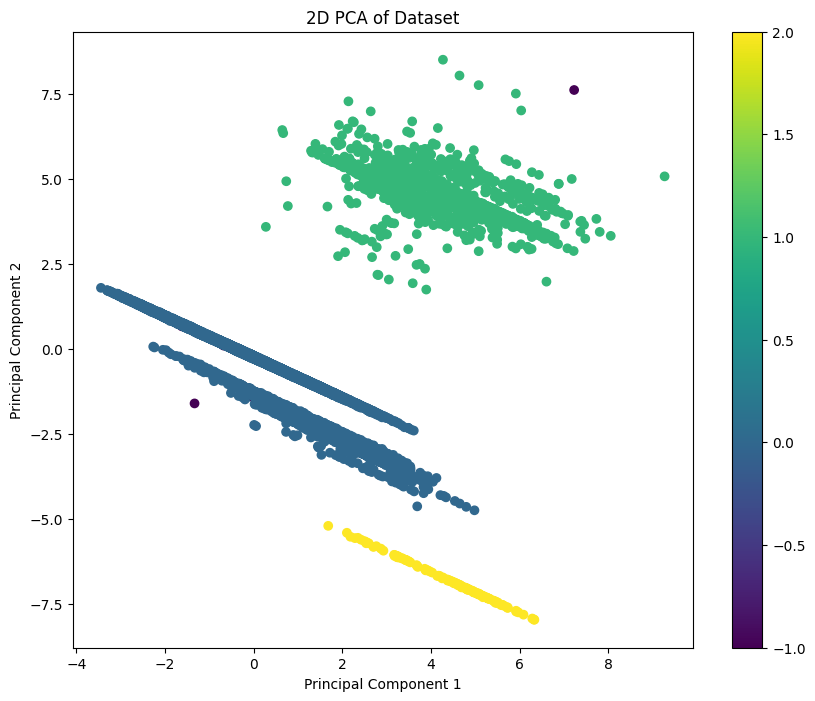

In [40]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def plot_clusters(df, labels):
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(df.drop(['Cluster'], axis=1))

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(principal_components[:, 0], principal_components[:, 1], c=labels, cmap='viridis', label=labels)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('2D PCA of Dataset')
    plt.colorbar(scatter)
    plt.show()

# Plotting the clusters
plot_clusters(adult_df_dbscan, adult_df_dbscan['Cluster'])


In [ ]:
# Calculate the mean or median of the features for each cluster
cluster_descriptions = adult_df_dbscan.groupby('Cluster').mean()  # or .median()

# Display the cluster centroids
print(cluster_descriptions)
cat_cols = adult_df_dbscan.select_dtypes(include=['object', 'category']).columns

# For categorical features, you can look at mode or counts
for column in cat_cols:
    print(f"\nFeature: {column}")
    print(adult_df_dbscan.groupby('Cluster')[column].value_counts(normalize=True))

# Visual examination of distributions
#import seaborn as sns

#for feature in ['education-num', 'age_binned_36-45', 'hours_per_week_binned_31-40']:  # example features
 #   plt.figure(figsize=(10, 5))
  #  sns.boxplot(x='Cluster', y=feature, data=adult_df_dbscan)
   # plt.title(f'Distribution of {feature} Across Clusters')
    #plt.show()


           fnlwgt  education-num  capital-gain  capital-loss  \
Cluster                                                        
-1       5.836680      -0.404087      1.772562      2.466020   
 0      -0.000160      -0.022834     -0.062024     -0.218586   
 1      -0.043873       0.343213     -0.147445      4.390585   
 2       0.019419       1.144925     13.354578     -0.218586   

         positive_capital_gain  positive_capital_loss  \
Cluster                                                 
-1                    1.006789               1.061763   
 0                   -0.002254              -0.222847   
 1                   -0.303112               4.487388   
 2                    3.299115              -0.222847   

         age_education_interaction  workclass_Federal-gov  \
Cluster                                                     
-1                        0.038336               0.181818   
 0                       -0.026758               0.030931   
 1                        0.

In [ ]:
import pandas as pd

def analyze_clusters(df, labels):
    # Append the cluster labels to your dataframe
    df['Cluster'] = labels
    
    # Compute summary statistics for each cluster
    cluster_summary = df.groupby('Cluster').agg({
        'Income': ['mean', 'median', 'std'],
        'Age': ['mean', 'median', 'std'],
        'Education': lambda x: x.mode().iloc[0]  # Most common value
    })
    
    print(cluster_summary)
    
    return cluster_summary


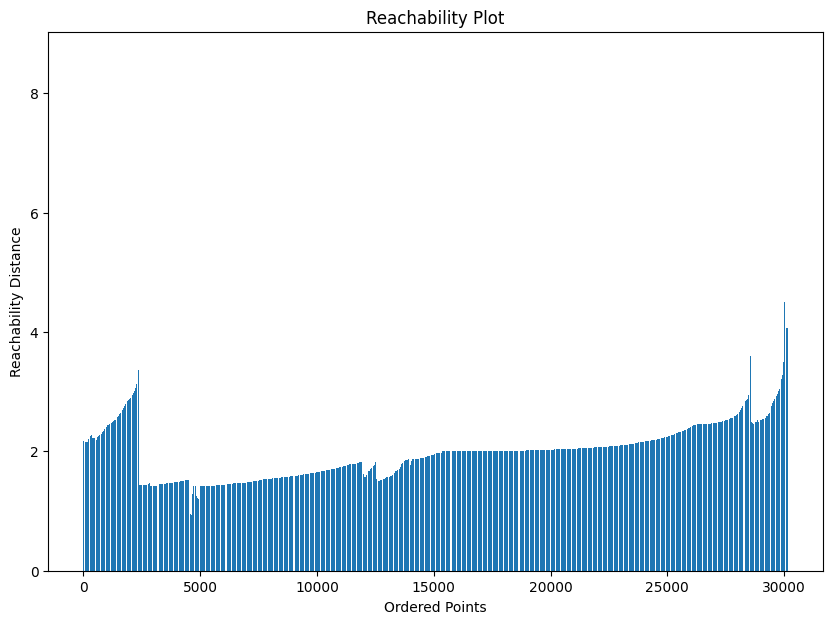

In [ ]:
from sklearn.cluster import OPTICS
def opticsPlot(df, min_samples):
    optics_model = OPTICS(min_samples=min_samples, xi=0.05, min_cluster_size=0.05)
    optics_model.fit(df)
    reachability = optics_model.reachability_[optics_model.ordering_]
    labels = optics_model.labels_[optics_model.ordering_]
    plt.figure(figsize=(10, 7))
    plt.bar(range(len(reachability)), reachability)
    plt.title('Reachability Plot')
    plt.xlabel('Ordered Points')
    plt.ylabel('Reachability Distance')
    plt.show()

opticsPlot(adult_df_dbscan, 130)


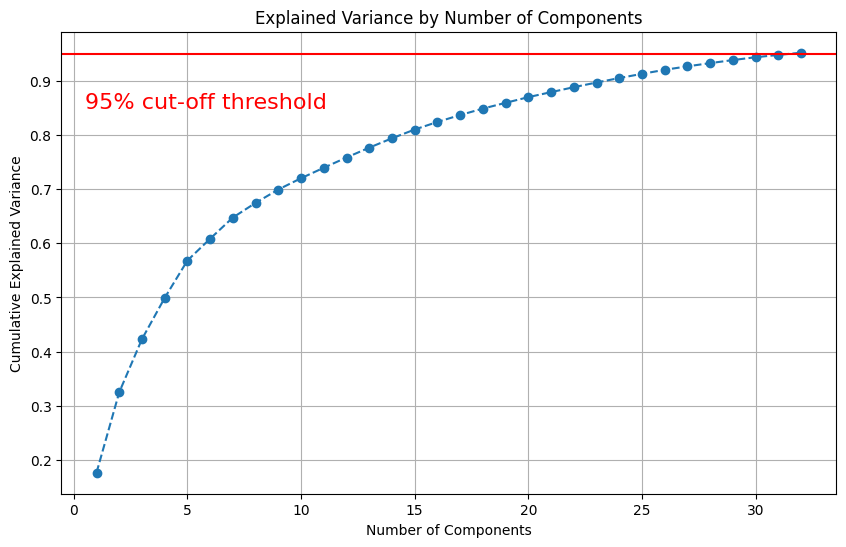

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Assuming X is your dataset as a numpy array
pca = PCA(n_components=32)
data_reduced = pca.fit_transform(X)

# Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Explained Variance by Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)

# Optional: Add a horizontal line to mark a threshold, e.g., 0.95 for 95% variance
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

plt.show()


# Clustering Bank

EPS: 1, Min_samples: 5, Score: -0.29559642512097567


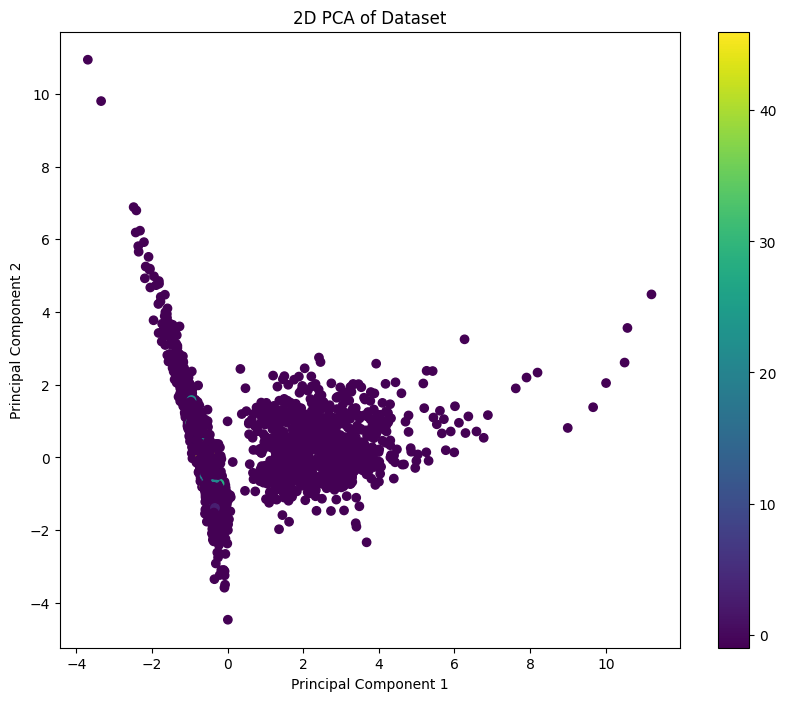

In [ ]:
from sklearn.cluster import DBSCAN
import numpy as np
from sklearn.metrics import silhouette_score

num_cols = bank_df_dbscan.select_dtypes(include=['int64', 'float64']).columns
X = bank_df_dbscan[num_cols]

from sklearn.decomposition import PCA

# Define parameter grid
eps = 1
min_samples = 5 # Example range for min_samples

# Initialize variables to store the best score and parameters



dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(bank_df_dbscan)
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
score = silhouette_score(bank_df_dbscan, clusters) if n_clusters > 1 else -1
print(f"EPS: {eps}, Min_samples: {min_samples}, Score: {score}")
            
            

bank_df_dbscan['Cluster'] = clusters

def plot_clusters(df, labels):
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(df.drop(['Cluster'], axis=1))

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(principal_components[:, 0], principal_components[:, 1], c=labels, cmap='viridis', label=labels)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('2D PCA of Dataset')
    plt.colorbar(scatter)
    plt.show()

# Plotting the clusters
plot_clusters(bank_df_dbscan, bank_df_dbscan['Cluster'])


In [ ]:
def estimate_dbscan_params(df, eps_values, min_samples_values):
    best_score = -1
    best_params = {'eps': None, 'min_samples': None}
    best_labels = None
    best_cluster_count = 0

    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(df)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

            if n_clusters > 1 and n_clusters  < 5:
                if -1 in labels:
                    silhouette = silhouette_score(df[labels != -1], labels[labels != -1])
                else:
                    silhouette = silhouette_score(df, labels)
                print(f"Testing eps={eps}, min_samples={min_samples}: silhouette={silhouette:.4f}, clusters={n_clusters}")

                # Consider both silhouette and cluster count in the score
                score = 2 * silhouette + np.log1p(n_clusters) - np.log1p(np.count_nonzero(labels == -1))
                print("Score: ", score)
                if score > best_score:
                    best_score = score
                    best_params = {'eps': eps, 'min_samples': min_samples}
                    best_labels = labels.copy()
                    best_cluster_count = n_clusters

    if best_params['eps']:
        print(f"Best Parameters: eps={best_params['eps']}, min_samples={best_params['min_samples']}, score={best_score:.4f}")
        print(f"Clusters found: {best_cluster_count}, Noise: {np.count_nonzero(best_labels == -1)}")
    else:
        print("No valid clustering configuration found.")
        best_labels = []

    return best_params, best_labels

eps_values = np.linspace(1, 7, int((7 - 1) / 0.5) + 1)
min_samples_values = range(1, 120, 5)  
best_params, best_labels = estimate_dbscan_params(bank_df_dbscan, eps_values, min_samples_values)



Testing eps=1.0, min_samples=11: silhouette=0.5855, clusters=3
Score:  -5.848350286414485
Testing eps=1.0, min_samples=16: silhouette=0.6160, clusters=2
Score:  -6.079000501513563
Testing eps=1.5, min_samples=31: silhouette=0.3256, clusters=2
Score:  -6.648522722874747
Testing eps=2.0, min_samples=11: silhouette=0.0702, clusters=3
Score:  -6.057985722640193
Testing eps=2.0, min_samples=16: silhouette=0.3302, clusters=2
Score:  -5.881532134264329
Testing eps=2.0, min_samples=26: silhouette=0.0483, clusters=2
Score:  -6.664676295469289
Testing eps=2.0, min_samples=31: silhouette=0.0055, clusters=3
Score:  -6.55006802523546
Testing eps=2.0, min_samples=36: silhouette=-0.0032, clusters=3
Score:  -6.625751117771462
Testing eps=2.0, min_samples=41: silhouette=0.0945, clusters=4
Score:  -6.295677467987776
Testing eps=2.0, min_samples=46: silhouette=0.1513, clusters=3
Score:  -6.469654642268243
Testing eps=2.0, min_samples=51: silhouette=0.1634, clusters=3
Score:  -6.488934938297518
Testing ep

KeyboardInterrupt: 

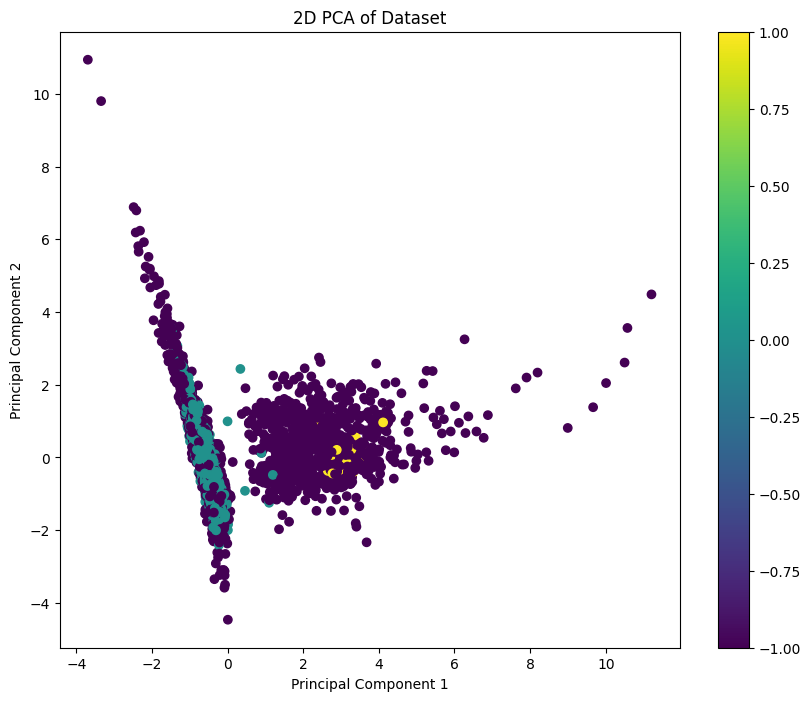

In [ ]:
def plot_clusters(df, labels):
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(df.drop(['Cluster'], axis=1))

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(principal_components[:, 0], principal_components[:, 1], c=labels, cmap='viridis', label=labels)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('2D PCA of Dataset')
    plt.colorbar(scatter)
    plt.show()

# Plotting the clusters
plot_clusters(bank_df_dbscan, bank_df_dbscan['Cluster'])


In [ ]:
# Calculate the mean or median of the features for each cluster
cluster_descriptions = bank_df_dbscan.groupby('Cluster').mean()  # or .median()

# Display the cluster centroids
print(cluster_descriptions)
cat_cols = bank_df_dbscan.select_dtypes(include=['object', 'category']).columns

# For categorical features, you can look at mode or counts
for column in cat_cols:
    print(f"\nFeature: {column}")
    print(bank_df_dbscan.groupby('Cluster')[column].value_counts(normalize=True))


          balance       day  duration  campaign     pdays  previous  \
Cluster                                                               
-1       0.206513  0.000828  0.205834  0.158983  0.417610  0.356149   
 0      -0.174608  0.008660 -0.171904 -0.132659 -0.405869 -0.318204   
 1      -0.269735 -0.644530 -0.415291 -0.328739  3.082655  0.708808   

         marital_divorced  marital_married  marital_single  education_primary  \
Cluster                                                                         
-1               0.171154         0.545673        0.283173           0.162019   
 0               0.071072         0.677057        0.251870           0.135079   
 1               0.028571         0.942857        0.028571           0.457143   

         ...  job_aggregated_management  job_aggregated_services  \
Cluster  ...                                                       
-1       ...                   0.200481                 0.094231   
 0       ...                   0.2

In [ ]:

print(bank_df_dbscan['Cluster'].value_counts())


Cluster
 0    2406
-1    2080
 1      35
Name: count, dtype: int64


# Test

In [ ]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import pandas as pd


# Assuming the data is already preprocessed and scaled
X = bank_df_dbscan.values  # Convert DataFrame to numpy array if not already

# Set parameters based on the number of dimensions (features)
dim = X.shape[1]
minPts = 2 * dim
k = 2 * dim - 1

# Compute the (2*dim-1)th nearest neighbor distance
nbrs = NearestNeighbors(n_neighbors=k).fit(X)
distances, indices = nbrs.kneighbors(X)

# The distance to the (2*dim-1)th nearest neighbor
eps = np.percentile(distances[:, k-1], 90)  # Using the 90th percentile as eps
# Apply DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=minPts)
clusters = dbscan.fit_predict(X)

bank_df_dbscan['Cluster'] = clusters
# Results
print("Cluster labels:", clusters)
print(bank_df_dbscan['Cluster'].value_counts())


Cluster labels: [0 0 0 ... 0 0 0]
Cluster
 0    4425
-1      96
Name: count, dtype: int64
